# Importing Libraries

In [5]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:
import torch
from torch.optim import Adam, SGD
from torch import nn, utils, save, load
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy, Precision, Recall

# Downloading the Dataset


The dataset used in the "Neural Networks and Deep Learning" by Michale Nielsen was organized as a zip of tuples
each tuple of length 2 represents: as the first element a 2d ndarray with (784, 1) shape, which represents a flattened (28x28) image,
the second element a nd array with (10, 1) which represents the value (the digit represented) of that image input,
the index where the number 1 is placed is the correct output
Given this context, we are not going to use the dataset given in the book, we've chosen to proceed using the mnist dataset from pytorch datasets.


In [7]:
# Transform PIL image into a tensor. The values are in the range [0, 1]
t = transforms.ToTensor()

# Load datasets for both training and testing.
mnist_training_28 = datasets.MNIST(root='/tmp/mnist', train=True, download=True, transform=t)
mnist_test_28 = datasets.MNIST(root='/tmp/mnist', train=False, download=True, transform=t)

0.3%

100.0%


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100.0%


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



100.0%


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100.0%

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



In [8]:
# Transform PIL image into a tensor. The values are in the range [0, 1]
# Upsampling to 224x224 images, not a really wise strategy, just for experimentation purposes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets for both training and testing.
mnist_training_224 = datasets.MNIST(root='/tmp/mnist', train=True, download=True, transform=transform)
mnist_test_224 = datasets.MNIST(root='/tmp/mnist', train=False, download=True, transform=transform)

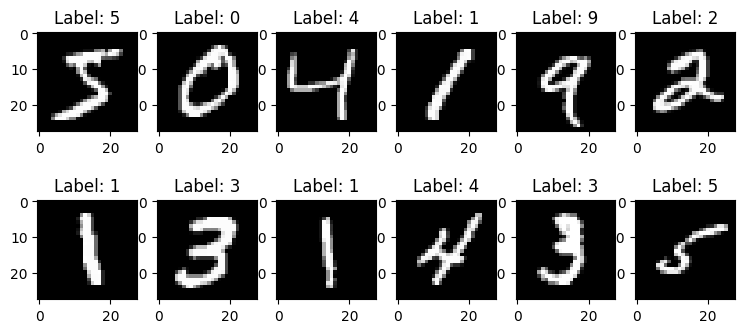

In [9]:
# Viewing the dataset
cols = 6
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(1.5*cols, 2*rows))

for i, ax in enumerate(axes.flatten()):
    image, label = mnist_training_28[i]
    ax.set_title(f"Label: {label}")
    ax.imshow(image.squeeze(0), cmap='gray')  # remove first dimension, hence it its a (1, 28, 28) tensor

plt.show()

# Helper Functions

In [10]:
#tensors shape summarizer function
def layer_summary(net, input_shape):
  X = torch.randn(*input_shape)
  for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

# LeNet

LeNet was one of the first architecture of covolutional neural networks, implemented around the 90's. It consisted in 2 convolutional layers, both followed by a average pooling layer, and 3 fully connected layers after those two convolutional.

In [6]:
class LeNet(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),
      nn.LazyLinear(84), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)


In [10]:
model = LeNet(10)
layer_summary(model.net, (1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Preparing

In [13]:
#Instance of the model
model_le = LeNet(10)
opt = Adam(model_le.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

### Training

In [14]:
losses_le = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader:
    predictions = model_le(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses_le.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.4609125852584839
Epoch 1: Loss = 0.4546559751033783
Epoch 2: Loss = 0.19963759183883667
Epoch 3: Loss = 0.1023150309920311
Epoch 4: Loss = 0.06971415132284164
Epoch 5: Loss = 0.1200936809182167
Epoch 6: Loss = 0.06274021416902542
Epoch 7: Loss = 0.08075117319822311
Epoch 8: Loss = 0.05467166006565094
Epoch 9: Loss = 0.04864850640296936


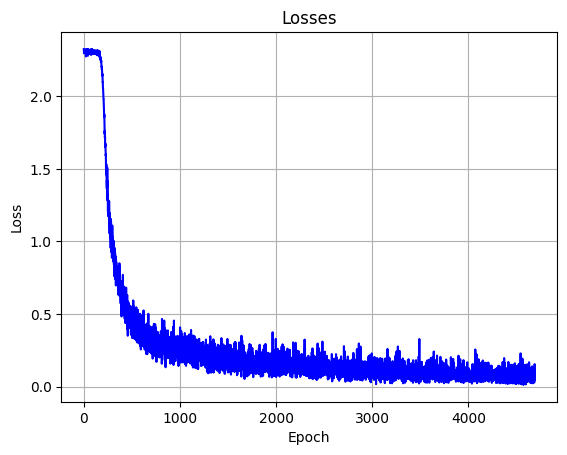

In [15]:
#Plot losses
plt.plot(losses_le, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [16]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9792


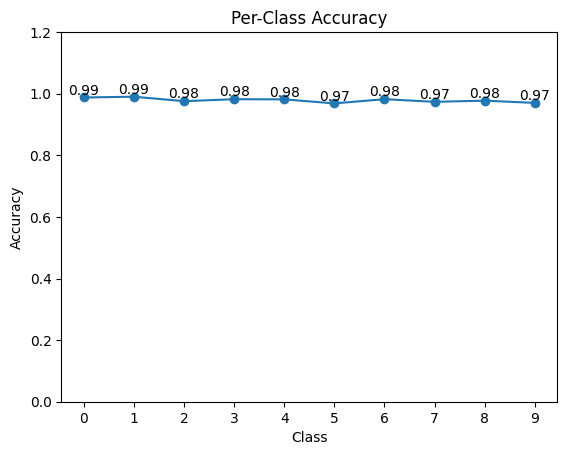

In [17]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [18]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

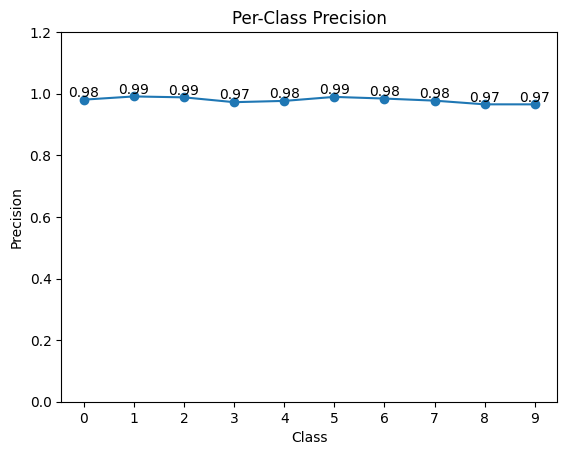

In [19]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [20]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

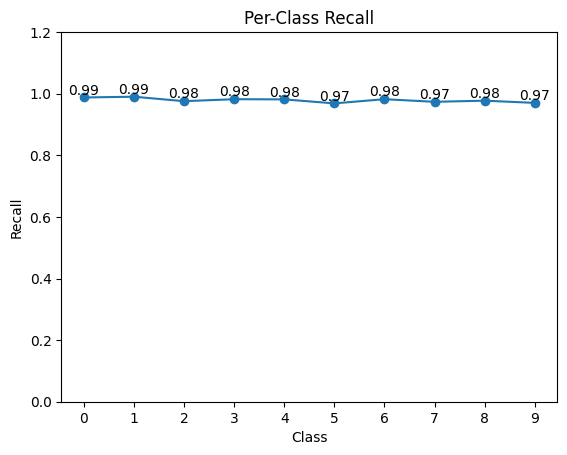

In [21]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# LeNet - 2

Implemented the same architechture as LeNetbut added:

- dropout to ensure generalization
- relu to ease training
- maxpooling to extract the features in a more relevant way

In [7]:
class LeNet_2(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),  nn.Dropout(p=0.5),
      nn.LazyLinear(84), nn.Sigmoid(), nn.Dropout(p=0.5),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

In [12]:
model = LeNet_2(10)
layer_summary(model.net, (1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### Preparing

In [22]:
#Instance of the model
model_le_2 = LeNet_2(10)
opt_2 = Adam(model_le_2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_2 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [23]:
losses_le_2 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_2:
    predictions = model_le_2(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_2.zero_grad()
    loss.backward()
    opt_2.step()

    losses_le_2.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.34910452365875244
Epoch 1: Loss = 0.26330599188804626
Epoch 2: Loss = 0.071400485932827
Epoch 3: Loss = 0.12331230193376541
Epoch 4: Loss = 0.2123749852180481
Epoch 5: Loss = 0.08021686226129532
Epoch 6: Loss = 0.049891117960214615
Epoch 7: Loss = 0.06168626621365547
Epoch 8: Loss = 0.09209421277046204
Epoch 9: Loss = 0.09026140719652176


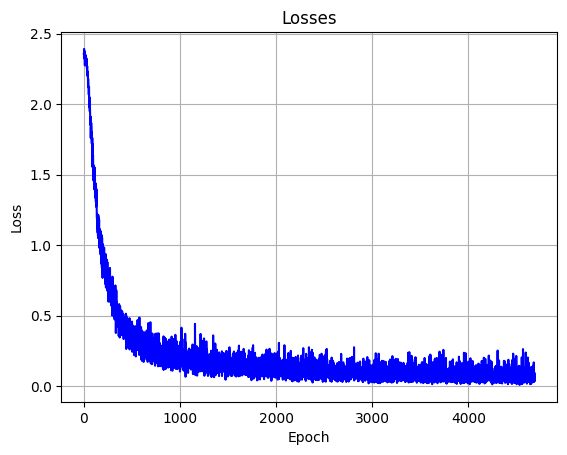

In [24]:
#Plot losses
plt.plot(losses_le_2, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [25]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_2(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9826


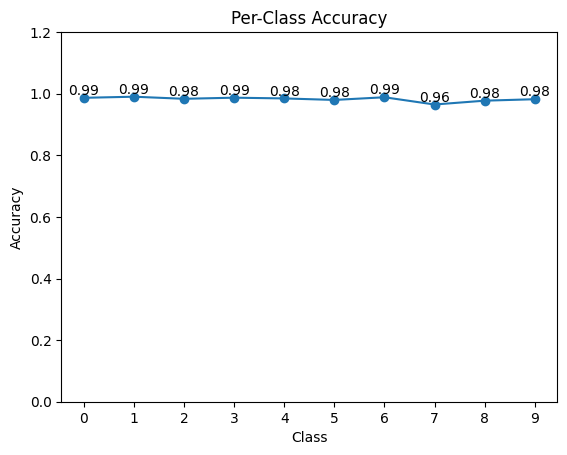

In [26]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [27]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

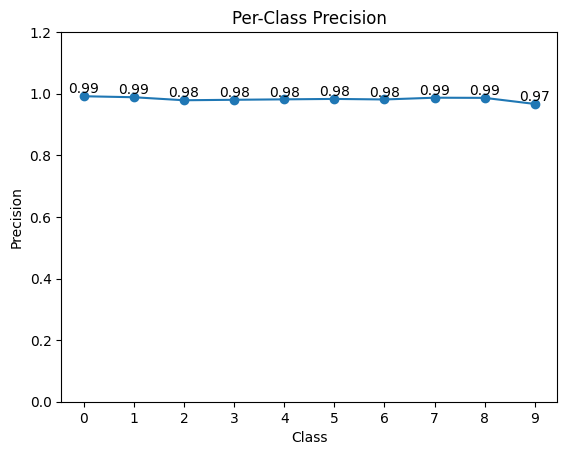

In [28]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall


In [29]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

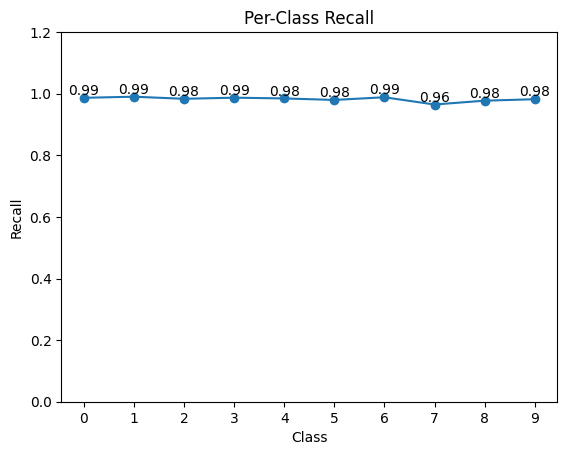

In [30]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# AlexNet


AlexNet was an evolution of LeNet, retaining the idea of multiple convolutional layers followed by fully connected layers. With increased computational capacity, AlexNet deepened and broadened the architecture, allowing timely training. It also introduced the relu activation function, which simplified training deep networks by requiring fewer mathematical operations. Additionally, max pooling was used instead of average pooling, leading to better feature comprehension. The incorporation of dropout, a regularization technique, further reduced overfitting by randomly deactivating neurons based on a probability, ensuring a more generalist model.

In [8]:
class AlexNet(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
      nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
      nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
      nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

In [11]:
model = AlexNet(10)
layer_summary(model.net, (1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### Preparing

In [31]:
#Instance of the model
model_alex = AlexNet(10)
opt_alex = Adam(model_alex.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_alex = utils.data.DataLoader(mnist_training_224, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

The process of training/testing was really long and tough, comparing to the other architechtures, there's just a little much to improve, so we are going to proceed in testing another alternatives for improvement of the results. Training a really wide + deep network in computers that weren't adequate isn't an easy task. 

Although we've had a lot of trouble training and testing, we've arrived to some results. The total accuracy was higher, but not significantly, some models can be easier to train and still have some great result withou all this pain

In [32]:
losses_al = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_alex:
    predictions = model_alex(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_alex.zero_grad()
    loss.backward()
    opt_alex.step()

    losses_al.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")


#saving the model to avoid further errors -> out of memory
with open('model_state.pt', 'wb') as f:
  save(model_alex.state_dict(), f)

Epoch 0: Loss = 0.08268454670906067
Epoch 1: Loss = 0.11645566672086716
Epoch 2: Loss = 0.013871601782739162
Epoch 3: Loss = 0.016680410131812096
Epoch 4: Loss = 0.030279777944087982
Epoch 5: Loss = 0.08899936825037003
Epoch 6: Loss = 0.007662383373826742
Epoch 7: Loss = 0.01114968117326498
Epoch 8: Loss = 0.001201842911541462
Epoch 9: Loss = 0.02312086522579193


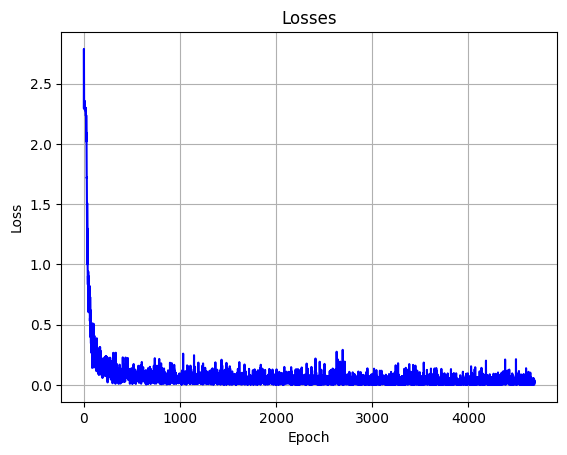

In [33]:
#Plot losses
plt.plot(losses_al, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [32]:
#getting the saved model from model_state
with open('model_state.pt', 'rb') as f:
    model_alex.load_state_dict(load(f))

### Accuracy

In [33]:
batch_size_test = 100
test_loader_alex = utils.data.DataLoader(mnist_test_224, batch_size=batch_size_test)

predicted_classes_list = []
labels_list = []

for imgs, labels in test_loader_alex:
    predictions = model_alex(imgs)
    predicted_classes_list.append(torch.argmax(predictions, dim=1))
    labels_list.append(labels)

predicted_classes = torch.cat(predicted_classes_list, dim=0)
labels = torch.cat(labels_list, dim=0)
   

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9892


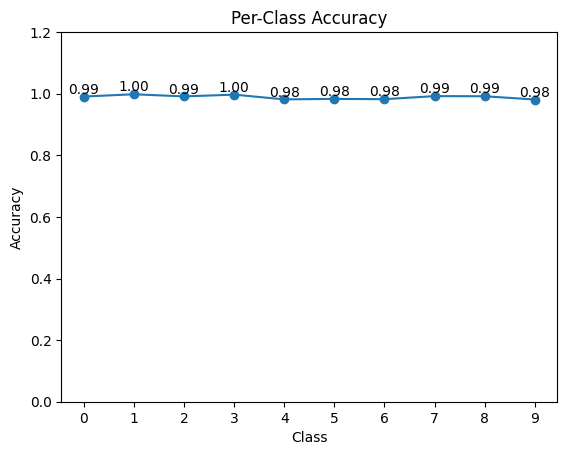

In [34]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [35]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

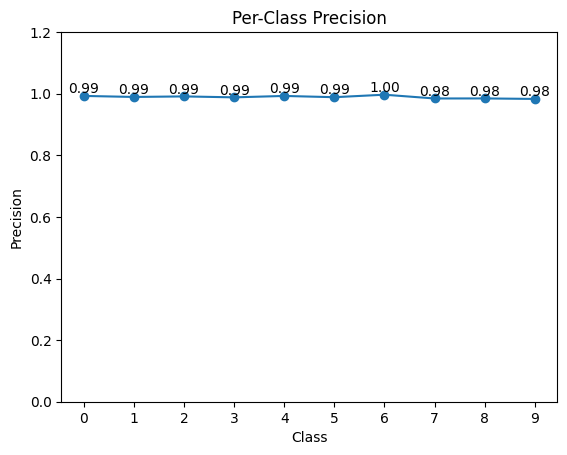

In [36]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [37]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

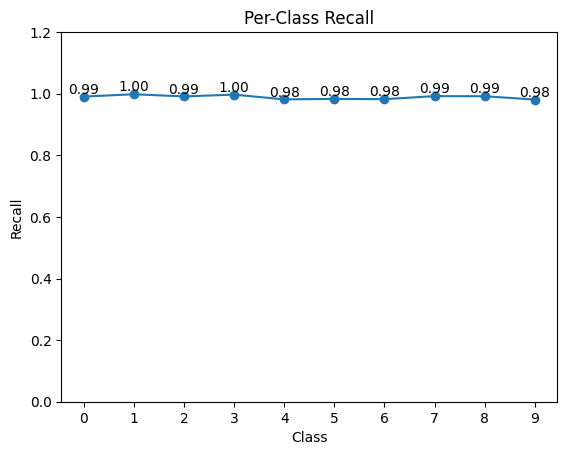

In [38]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# NiN (Network in Network)

In [19]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU()
    )

In [20]:
class NiN(nn.Module):
    def __init__(self, lr=0.1, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes

        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)


In [21]:
model_nin = NiN()
layer_summary(model_nin.net, (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


### Preparing

In [22]:
#Instance of the model
model_nin = NiN(lr=1e-3)
opt_nin = Adam(model_nin.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_nin = utils.data.DataLoader(mnist_training_224, batch_size=batch_size, shuffle=True)

### Training


In [23]:
losses_nin = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_nin:
    predictions = model_nin(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_nin.zero_grad()
    loss.backward()
    opt_nin.step()

    losses_nin.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 1.737493872642517
Epoch 1: Loss = 1.7368497848510742
Epoch 2: Loss = 1.8320798873901367
Epoch 3: Loss = 1.4606302976608276
Epoch 4: Loss = 1.3540290594100952
Epoch 5: Loss = 1.3025556802749634
Epoch 6: Loss = 1.6698065996170044
Epoch 7: Loss = 1.4461332559585571
Epoch 8: Loss = 1.3962665796279907
Epoch 9: Loss = 1.4569950103759766


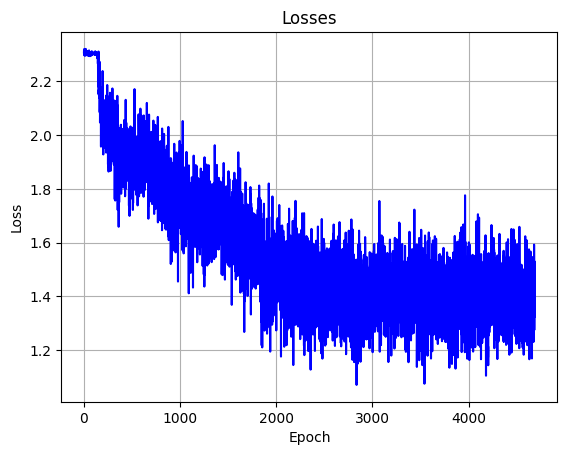

In [25]:
#Plot losses
plt.plot(losses_nin, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [27]:
batch_size_test = 100
test_loader_nin = utils.data.DataLoader(mnist_test_224, batch_size=batch_size_test)

predicted_classes_list = []
labels_list = []

for imgs, labels in test_loader_nin:
    predictions = model_nin(imgs)
    predicted_classes_list.append(torch.argmax(predictions, dim=1))
    labels_list.append(labels)

predicted_classes = torch.cat(predicted_classes_list, dim=0)
labels = torch.cat(labels_list, dim=0)
   

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.5050


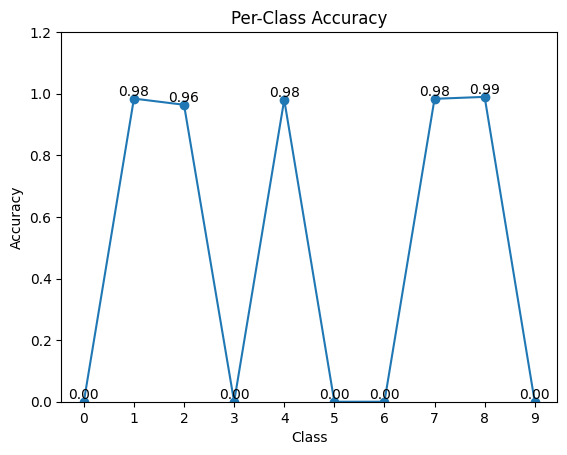

In [28]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [29]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

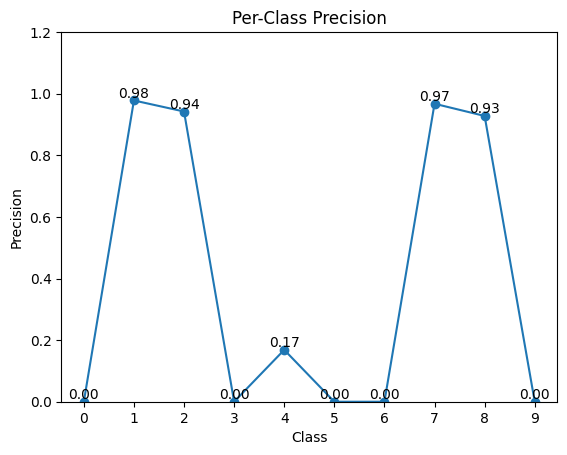

In [30]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [31]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

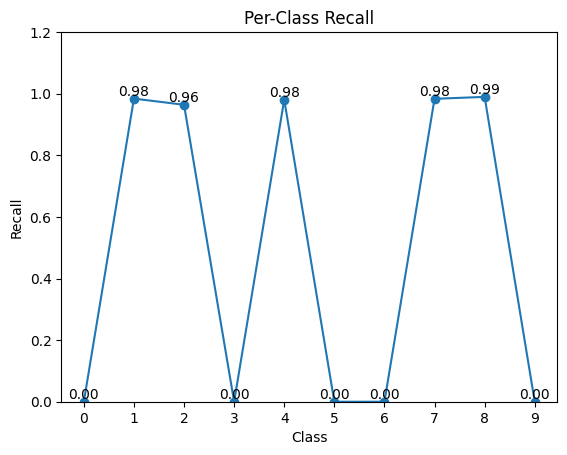

In [32]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# References

This notebook is based on the books:

"Dive into deep learning" by Aston Zhang, Zack C. Lipton, Mu Li and Alex J. Smola.

"Neural Networks and Deep Learning" by Michael Nielsen.